In [1]:
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io as sio
import skimage.io
import h5py

import sys
sys.path.append('../Metric/')
from Metric import *

In [22]:
# top-left coordinate should be of shape (n, 2)
def get_patches(raw_image, road_mask, topleft_coordinate, step):
    X = []
    Y = []
    for coord in topleft_coordinate:
        X.append(raw_image[:, coord[0]:coord[0]+step, coord[1]:coord[1]+step].flatten())
        Y.append(road_mask[int(coord[0]+step/2), int(coord[1]+step/2)])
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

Load & Reorder:

In [3]:
# Load
path_raw_image = "../../Data/090085/090085_20170531.h5"
path_road_mask = "../../Data/090085/Road_Data/motor_trunk_pri_sec_tert/motor_trunk_pri_sec_tert.tif"
path_topleft_coordinate = "../../Data/090085/Road_Data/motor_trunk_pri_sec_tert/topleft_coordinate.h5"

raw_image = np.array(h5py.File(path_raw_image)['scene'])
raw_image[np.where(raw_image == -9999)] = 0
road_mask = skimage.io.imread(path_road_mask)

data = h5py.File(path_topleft_coordinate, 'r')
topleft_coordinate = np.array(data['topleft_coordinate'])
data.close()

print(raw_image.shape, road_mask.shape)
print(raw_image.min())

(7, 7961, 8091) (7961, 8091)
-2000


In [4]:
# Construct training & test set
index_mask = np.arange(topleft_coordinate.shape[0])
np.random.shuffle(index_mask)

train_index = index_mask[:int(index_mask.size*0.75)]
test_index = index_mask[int(index_mask.size*0.75):]

print(index_mask.shape, train_index.shape, test_index.shape)

(17154396,) (12865797,) (4288599,)


Model parameters: 

In [5]:
width = 28
height = 28
band = 7

L1_out = 512
L2_out = 256
L3_out = 128
L4_out = 64
class_output = 1 # number of possible classifications for the problem

batch_size = 64
learning_rate = 9e-6
iteration = 50000

Calculate Normalization Parameters:

In [6]:
# Normalize Parameters
mu = 0
sigma = 0
step = width
for idx in train_index:
    img_idx = topleft_coordinate[idx]
    cur_img = raw_image[:, img_idx[0]:img_idx[0]+step, img_idx[1]:img_idx[1]+step].flatten()
    mu += cur_img
mu = mu / train_index.size

for idx in train_index:
    img_idx = topleft_coordinate[idx]
    cur_img = raw_image[:, img_idx[0]:img_idx[0]+step, img_idx[1]:img_idx[1]+step].flatten()
    sigma += (cur_img-mu)**2
sigma = sigma / train_index.size

print(mu.shape, sigma.shape)

(5488,) (5488,)


Place holders for inputs and outputs: 

In [7]:
x = tf.placeholder(tf.float32, shape=[None, width*height*band], name='x')
y = tf.placeholder(tf.float32, shape=[None, class_output], name='y')

Fully Connected Layer: 

In [8]:
# Layer 1
W_fc1 = tf.Variable(tf.truncated_normal([width*height*band, L1_out], stddev=0.1))
b_fc1 = tf.Variable(tf.truncated_normal([L1_out], stddev=0.1))

fc1=tf.matmul(x, W_fc1) + b_fc1 # applying weights and biases
h_fc1 = tf.nn.relu(fc1) # ReLU activation

# Layer 2
W_fc2 = tf.Variable(tf.truncated_normal([L1_out, L2_out], stddev=0.1))
b_fc2 = tf.Variable(tf.truncated_normal([L2_out], stddev=0.1))

fc2=tf.matmul(h_fc1, W_fc2) + b_fc2# applying weights and biases
h_fc2 = tf.nn.relu(fc2) # ReLU activation

# Layer 3
W_fc3 = tf.Variable(tf.truncated_normal([L2_out, L3_out], stddev=0.1))
b_fc3 = tf.Variable(tf.truncated_normal([L3_out], stddev=0.1))

fc3=tf.matmul(h_fc2, W_fc3) + b_fc3
h_fc3 = tf.nn.relu(fc3) # ReLU activation

# Layer 4
W_fc4 = tf.Variable(tf.truncated_normal([L3_out, L4_out], stddev=0.1))
b_fc4 = tf.Variable(tf.truncated_normal([L4_out], stddev=0.1))

fc4=tf.matmul(h_fc3, W_fc4) + b_fc4
h_fc4 = tf.nn.relu(fc4) # ReLU activation

Output Layer (Softmax):

In [9]:
W_fc_out = tf.Variable(tf.truncated_normal([L4_out, class_output], stddev=0.1))
b_fc_out = tf.Variable(tf.truncated_normal([class_output], stddev=0.1))

fc_out = tf.matmul(h_fc4, W_fc_out) + b_fc_out

y_CNN = tf.sigmoid(fc_out, name='y_CNN')
prediction = tf.cast(tf.round(y_CNN), tf.int32, name='prediction')

Cost function & optimizer:

In [10]:
cross_entropy = -tf.reduce_mean(tf.reduce_sum((y * tf.log(y_CNN) + (1-y) * tf.log(1-y_CNN)), axis=1))
cross_entropy_sum = -tf.reduce_sum(y * tf.log(y_CNN)+(1-y) * tf.log(1-y_CNN))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

In [11]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(y, tf.round(y_CNN)), "float"))

Train & monitor:

In [12]:
saver = tf.train.Saver()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

batch_num = int(train_index.size/batch_size)

learning_curve = []
for i in range(iteration):
    start = i%batch_num * batch_size
    end = start + batch_size

    if end > train_index.size:
        end = train_index.size
        np.random.shuffle(train_index)

    index = train_index[start:end]
    batch_x, batch_y = get_patches(raw_image, road_mask, topleft_coordinate[index], step=width)
    batch = [((batch_x-mu)/sigma), np.matrix(batch_y).astype(int).T]

    # snap shot
    if i%1000 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y: batch[1]})
        learning_curve.append(train_accuracy)
        
    train_step.run(feed_dict={x: batch[0], y: batch[1]})
print("finish")

finish


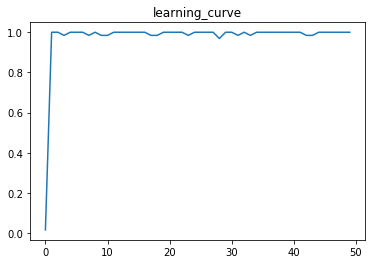

In [13]:
# plot training curve
plt.figsize=(9,5)
plt.plot(learning_curve)
plt.title('learning_curve')
plt.show()

(Optional) Save the model

In [14]:
save_path = './Result/motor_trunk_pri_sec_tert/'
model_name = 'motor_trunk_pri_sec_tert'
saver.save(sess, save_path + model_name)

h5f = h5py.File(save_path + "training_info.h5", 'w')

h5f_Index = h5f.create_group("Index")
h5f_Index.create_dataset(name='train_index', shape=train_index.shape, data=train_index)
h5f_Index.create_dataset(name='test_index', shape=test_index.shape, data=test_index)

h5f_Norm = h5f.create_group("Norm")
h5f_Norm.create_dataset(name='mu', shape=mu.shape, data=mu)
h5f_Norm.create_dataset(name='sigma', shape=sigma.shape, data=sigma)
h5f.close()

Evaluate:

In [2]:
train_metric = Metric()

batch_num = int(train_index.size/batch_size)+1
for i in range(batch_num):
    start = i%batch_num * batch_size
    end = start + batch_size

    if end > train_index.size:
        end = train_index.size
    
    index = train_index[start:end]
    batch_x, batch_y = get_patches(raw_image, road_mask, topleft_coordinate[index], step=width)
    batch = [((batch_x-mu)/sigma), np.matrix(batch_y).astype(int).T]
    
    # record metric
    pred = prediction.eval(feed_dict={x:batch[0]})
    train_metric.accumulate(pred, batch[1])
    
train_metric.print_info()

NameError: name 'Metric' is not defined

In [37]:
test_metric = Metric()

batch_num = int(test_index.size/batch_size)+1
for i in range(batch_num):
    start = i%batch_num * batch_size
    end = start + batch_size

    if end > test_index.size:
        end = test_index.size
    
    index = test_index[start:end] 
    batch_x, batch_y = get_patches(raw_image, road_mask, topleft_coordinate[index], step=width)
    batch = [((batch_x-mu)/sigma), np.matrix(batch_y).astype(int).T]

    # record metric   
    pred = prediction.eval(feed_dict={x:batch[0], y: batch[1]})        
    test_metric.accumulate(pred, batch[1])
    
test_metric.print_info()

true_pos  = 0
false_pos = 16548
true_neg  = 4272051
false_neg = 0
size = 4288599
pos_recall    = nan
pos_precision = 0.0
pos_F1        = nan
neg_precision = 1.0
neg_recall    = 0.996141397226
neg_F1        = 0.998066969214
accuracy      = 0.996141397226
16548.0


../Metric/Metric.py:50: RuntimeWarning: invalid value encountered in long_scalars
  pos_recall = true_pos / (true_pos + false_neg)
